##### Plot log-evidence and objective function for varying logarithm of hyperparameter (2D case)

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2
Nphi = 2
acoeff  = np.ones((1,K))
mu  = np.zeros((Nphi,K))
Sig = np.zeros((Nphi,Nphi,K))
mu[0,0] = 1.0
mu[1,1] = 1.0
rho = -0.9
var = 0.05
fac = 0.25
Sig[:,:,0] = [[var,var*rho],[var*rho,var]]
Sig[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]
r = 1e-0
s = 1e-0

In [3]:
Bmat = np.zeros((Nphi,Nphi,K))
Pmat = np.zeros((Nphi,Nphi,K))
mVec = np.zeros((Nphi,K))
Wraw = np.zeros((1,K))
Vmat = np.zeros((Nphi,K))
jVec = np.zeros((Nphi,1))
LEjvec = np.zeros((Nphi,1))
Hmat = np.zeros((Nphi,Nphi))

In [4]:
def poststat(X,logalp):
    alp = np.exp(logalp)
    A = np.diag(alp)
    Ain = np.diag(1/alp)
    for i in range(0,K):
        Bmat[:,:,i] = Sig[:,:,i] + Ain
        Wraw[0,i] = acoeff[0,i]*st.multivariate_normal.pdf(mu[:,i],[0]*Nphi,Bmat[:,:,i])
        Pmat[:,:,i] = Ain - Ain@la.inv(Bmat[:,:,i])@Ain
        mVec[:,i] = Pmat[:,:,i]@la.inv(Sig[:,:,i])@mu[:,i]
        for j in range(0,Nphi):
            Vmat[j,i] = (1 - alp[j]*Pmat[j,j,i] - alp[j]*(mVec[j,i]**2))/(2.0*alp[j])
    LogEvid= np.log(np.sum(Wraw))
    ObjFun = LogEvid + np.sum(r*logalp-s*alp)
    Wwght = Wraw/np.sum(Wraw)
    for i in range(0,Nphi):
        LEjvec[i,0] = np.dot(Wwght,Vmat[i,:])
        jVec[i,0]   = alp[i]*LEjvec[i,0] + r - s*alp[i]
    PostPdf = 0.0
    LikFun = 0.0
    for i in range(0,K):
        LikFun  = LikFun  + acoeff[0,i]*st.multivariate_normal.pdf(X,mu[:,i],Sig[:,:,i])
        PostPdf = PostPdf + Wwght[0,i]*st.multivariate_normal.pdf(X,mVec[:,i],Pmat[:,:,i])  
    PriorPdf = st.multivariate_normal.pdf(X,[0]*Nphi,Ain)
    for i in range(0,Nphi):
        for jj in range(0,i):
            Hmat[i,jj] = Hmat[jj,i]
        for j in range(0,Nphi):
            temp = 0.0
            for k in range(0,K):
                temp = temp + Wwght[0,k]*(0.5*Pmat[i,j,k]**2 + mVec[i,k]*mVec[j,k]*Pmat[i,j,k] + Vmat[j,k]*(Vmat[i,k] - LEjvec[i,0])) 
            Hmat[i,j] = logalp[i]*logalp[j]*temp
    return PriorPdf, LikFun, PostPdf, LogEvid, ObjFun, jVec

In [5]:
Ngrd  = 100
LogEvidgrd  = np.zeros((Ngrd,Ngrd))
ObjFungrd   = np.zeros((Ngrd,Ngrd))
JacVecgrd   = np.zeros((Ngrd,Ngrd,Nphi))
LogAlp1bnd = [-5,10]
LogAlp2bnd = [-5,10]
LogAlp1rng = np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],Ngrd)
LogAlp2rng  = np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],Ngrd)
LogAlp1grd,LogAlp2grd = np.meshgrid(LogAlp1rng,LogAlp2rng)
Xarb = np.array([0.0,0.0])
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        LogAlpCur = np.array([LogAlp1grd[i,j],LogAlp2grd[i,j]])
        PRi, LFi, PSi, LogEvidgrd[i,j], ObjFungrd[i,j], Jtmp = poststat(Xarb,LogAlpCur)
        JacVecgrd[i,j,:] = Jtmp[:,0]

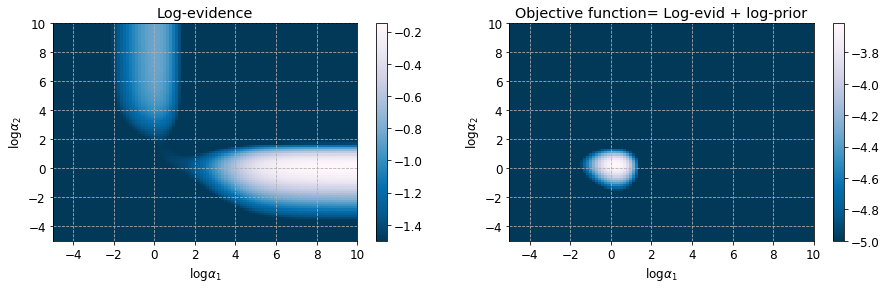

In [9]:
mpl.rcParams.update({'font.size':12})
minVal = -1.5
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 2, 1)
plt.pcolor(LogAlp1grd,LogAlp2grd,LogEvidgrd,cmap='PuBu_r',vmin=minVal)
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Log-evidence')

plt.subplot(1, 2, 2)
plt.pcolor(LogAlp1grd,LogAlp2grd,ObjFungrd,cmap='PuBu_r',vmin=-5)
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Objective function= Log-evid + log-prior')
plt.savefig('plot_evid.eps',bbox_inches='tight')

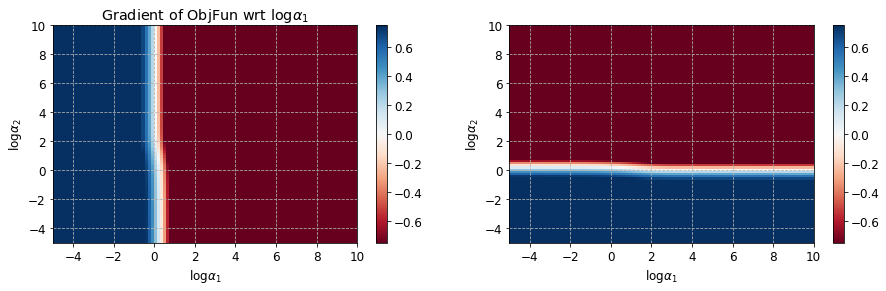

In [7]:
mpl.rcParams.update({'font.size':12})
minVal =-0.75
maxVal =0.75
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 2, 1)
plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,0],cmap='RdBu',vmin=minVal,vmax=maxVal)
#plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,0],cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title(r'Gradient of ObjFun wrt $\log\alpha_1$')

plt.subplot(1, 2, 2)
plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,1],cmap='RdBu',vmin=minVal,vmax=maxVal)
#plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,1],cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
#plt.title(r'Gradient of ObjFun wrtp(φ|D) = N (φ|[1, 0], Σ
#(1)) + N (φ|[0, 1], Σ
#(2)) ( $\log\alpha_2$')
plt.savefig('plot_jac.eps',bbox_inches='tight')

In [8]:
# %matplotlib qt
# sminVal = -5.5
# smaxVal = -0.5
# fig = plt.figure(2)
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(LogAlp1grd,LogAlp2grd,ObjFungrd, cmap='PuBu_r',linewidth=0, antialiased=False,vmin=sminVal, vmax=smaxVal)
# ax.set_zlim(sminVal,smaxVal)
# ax.set_xlabel('alpha1')
# ax.set_ylabel('alpha2')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# fig.colorbar(surf)